In [1]:
#@title Task 1 & 2 Summary – What This Notebook Does

"""
Overview:
This notebook implements Task 1 and Task 2 of the Image Captioning Lab.

Task 1: Image Feature Extraction
- We use a pretrained CNN (ResNet50) to extract visual features from images.
- The image is resized and normalized to match the expected input format of the CNN.
- The CNN outputs a feature map representing the image’s content.
- These feature vectors are passed on to the caption model.

Task 2: Language (Caption) Model
- We define a caption decoder using an LSTM network.
- The model takes a sequence of word indices (representing a caption) and learns to generate the next word.
- This decoder will eventually work alongside the image features to generate meaningful captions.
- For now, we test it using dummy data (fake captions) to verify it's working.

Notebook Structure:
-    Hyperparameters
1. Install required libraries
2. Import all dependencies
3. Define the ImageEncoder class (ResNet50-based)
4. Define image transformation & loading functions
5. Preview original images from the dataset (grid of 10)
6. Show how the model sees images after transformation
7. Define the CaptionDecoder class (LSTM-based)
8. Test the decoder using dummy input to verify shape and functionality

✅ Goal of Task 1 & 2:
- Prepare the core components of the image captioning system.
- Make sure the image encoder and text decoder work independently before combining them in Task 3.

🔄 Next Steps (for Task 3 group):
- Fuse image and text features
- Train the model using real image-caption pairs
- Generate and evaluate captions
"""
#Note: The Flicker8k_Dataset is only being used as a dummy source of real images to test image preprocessing and feature extraction.

"\nOverview:\nThis notebook implements Task 1 and Task 2 of the Image Captioning Lab.\n\nTask 1: Image Feature Extraction\n- We use a pretrained CNN (ResNet50) to extract visual features from images.\n- The image is resized and normalized to match the expected input format of the CNN.\n- The CNN outputs a feature map representing the image’s content.\n- These feature vectors are passed on to the caption model.\n\nTask 2: Language (Caption) Model\n- We define a caption decoder using an LSTM network.\n- The model takes a sequence of word indices (representing a caption) and learns to generate the next word.\n- This decoder will eventually work alongside the image features to generate meaningful captions.\n- For now, we test it using dummy data (fake captions) to verify it's working.\n\nNotebook Structure:\n-    Hyperparameters\n1. Install required libraries\n2. Import all dependencies\n3. Define the ImageEncoder class (ResNet50-based)\n4. Define image transformation & loading functions\n

In [2]:
#@title 1. Install Required Libraries
%pip install torchvision
%pip install nltk
%pip install pillow
#@title Download Flickr8k Sample Dataset (Optional for Colab)
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip -q Flickr8k_Dataset.zip



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#@title 2. Import Libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import nltk
from torch.nn.utils.rnn import pack_padded_sequence

nltk.download('punkt')


[nltk_data] Downloading package punkt to C:\Users\Deborah
[nltk_data]     Aittokallio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
#@title  Hyperparameters

batch_size = 1              # Number of samples processed at once
caption_length = 10         # Length of dummy/test captions
vocab_size = 5000           # Simulated vocabulary size (real vocab will come in Task 3)
embed_size = 256            # Embedding dimension for words
hidden_size = 512           # LSTM hidden state size
num_layers = 1              # Number of LSTM layers


In [5]:
#@title 3. Define Image Encoder (CNN)

class ImageEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # remove last fc and avgpool
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
        for param in self.resnet.parameters():  #  fixed typo here
            param.requires_grad = False  # freeze pretrained CNN

    def forward(self, images):
        features = self.resnet(images)             # (batch_size, 2048, H/32, W/32)
        features = self.adaptive_pool(features)    # (batch_size, 2048, 14, 14)
        features = features.permute(0, 2, 3, 1)     # (batch_size, 14, 14, 2048)
        return features


In [6]:
#@title 4. Image Preprocessing Function

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # (1, 3, 256, 256)
    return image

# Load and encode a sample image (replace 'sample.jpg' with your image)
image_tensor = load_image(r"C:\Users\Deborah Aittokallio\Downloads\Flickr8k_Dataset\Flicker8k_Dataset\667626_18933d713e.jpg")
encoder = ImageEncoder()

with torch.no_grad():
    image_features = encoder(image_tensor)

print("Image feature shape:", image_features.shape)


c:\Users\Deborah Aittokallio\.conda\envs\ai-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Deborah Aittokallio\.conda\envs\ai-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image feature shape: torch.Size([1, 14, 14, 2048])


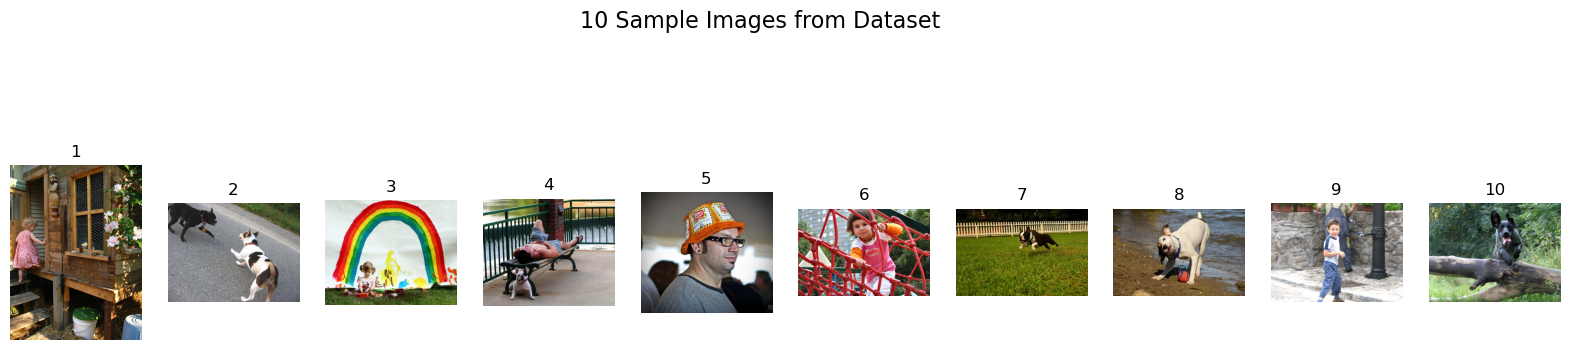

In [7]:
#@title 5. Show 10 Original Images (Preview as Grid)
import matplotlib.pyplot as plt
import os
from PIL import Image

# Folder where your dataset is stored
image_folder = r"C:\Users\Deborah Aittokallio\Downloads\Flickr8k_Dataset\Flicker8k_Dataset"

# Get first 10 JPEG images in the folder
all_images = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
sample_images = all_images[:10]  # pick first 10 (or use random.sample for randomness)

# Plot them in a horizontal row
plt.figure(figsize=(20, 5))

for i, image_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, image_name)
    image = Image.open(img_path).convert('RGB')
    plt.subplot(1, 10, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{i+1}")

plt.suptitle("10 Sample Images from Dataset", fontsize=16)
plt.show()


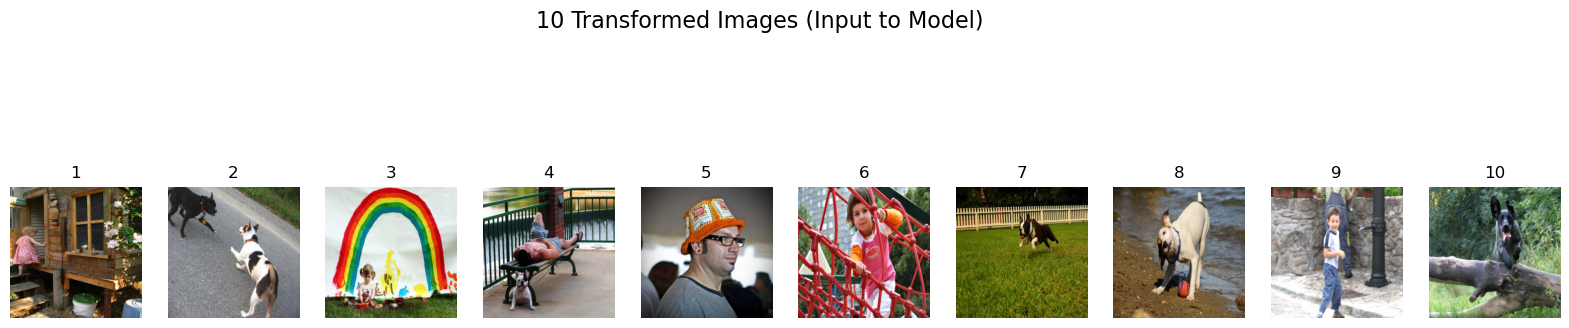

In [8]:
#@title 6. Show 10 Transformed Images (Post-Processing)

def show_transformed_images(image_folder, image_names, transform):
    plt.figure(figsize=(20, 5))

    for i, image_name in enumerate(image_names):
        img_path = os.path.join(image_folder, image_name)
        image = Image.open(img_path).convert('RGB')
        transformed = transform(image).unsqueeze(0)  # add batch dimension

        # Undo normalization for display
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        transformed = transformed.squeeze(0)  # remove batch dimension
        transformed = transformed * std[:, None, None] + mean[:, None, None]
        transformed = transformed.clamp(0, 1)

        np_image = transformed.permute(1, 2, 0).numpy()

        plt.subplot(1, 10, i + 1)
        plt.imshow(np_image)
        plt.axis('off')
        plt.title(f"{i+1}")

    plt.suptitle("10 Transformed Images (Input to Model)", fontsize=16)
    plt.show()

# Reuse the folder and image list from step 5
show_transformed_images(image_folder, sample_images, transform)


In [9]:
#@title 5. Define Caption Decoder (LSTM)

class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CaptionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size

    def forward(self, captions, features, lengths):
        embeddings = self.embed(captions)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs


In [10]:
#@title 8. Test Decoder with Dummy Caption Input
# Decoder Test (Structure Only)

"""
We're only testing the decoder model here — not generating actual captions yet.

- Creates random word indices to simulate a caption (dummy input)
- Passes them through the decoder with image features
- Output is a `(10, 5000)` tensor of raw prediction scores (not human-readable words)
- Actual caption generation happens after training, during inference
"""

# Define dummy parameters
batch_size = 1
vocab_size = 5000       # 🔁 pretend you have 5000 words in your vocabulary
embed_size = 256        # 📐 each word is represented by a 256-dim vector
hidden_size = 512       # 🧠 LSTM hidden state size
caption_length = 10     # 📝 pretend the caption is 10 words long

# Create dummy caption tokens: shape = (batch_size, caption_length)
dummy_captions = torch.randint(0, vocab_size, (batch_size, caption_length))

# Simulate caption length list (used by pack_padded_sequence)
dummy_lengths = [caption_length]

# Initialize the decoder
decoder = CaptionDecoder(embed_size, hidden_size, vocab_size, num_layers)

# Forward pass through the decoder
outputs = decoder(dummy_captions, image_features, dummy_lengths)

# Output shape should be (total_words, vocab_size) = (10, 5000)
print("Decoder output shape:", outputs.shape)


Decoder output shape: torch.Size([10, 5000])
